In [1]:
# Import libraries
from pathlib import Path
import os
import shutil
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2


In [2]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [3]:
CLASSES = ['all', 'hem']

# Define directory paths
ORIG_BASE_PATH = Path("C-NMC_Leukemia")
TRAINING_DATA_PATH = ORIG_BASE_PATH.joinpath("training_data")
VALIDATION_DATA_PATH = ORIG_BASE_PATH.joinpath("validation_data")
TEST_DATA_PATH = ORIG_BASE_PATH.joinpath("testing_data")

# Define training data paths
AUG_BASE_PATH = Path('new_all_hem')
AUG_ALL_PATH = AUG_BASE_PATH.joinpath("new_all")
AUG_HEM_PATH = AUG_BASE_PATH.joinpath("new_hem")

# Define crop paths
AUG_CROP_BASE_PATH = Path('new_all_hem_crop')
AUG_ALL_CROP_PATH = AUG_CROP_BASE_PATH.joinpath("new_all_crop")
AUG_HEM_CROP_PATH = AUG_CROP_BASE_PATH.joinpath("new_hem_crop")

In [4]:
from keras.models import Model, Sequential
from keras.layers import Input, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Rescaling, Dense

In [5]:
## Build the model
IMAGE_SIZE=112
backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-15 17:40:38.474017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-15 17:40:38.474701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
MODEL_NAME = 'ALL_HEM_FEATURE_EXTRACTOR'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
outputs = GlobalAveragePooling2D()(x)
#outputs = Flatten()(x)
model_1 = Model(inputs, outputs, name=MODEL_NAME)
model_1.summary()


Model: "ALL_HEM_FEATURE_EXTRACTOR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 112, 112, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 112, 112, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 112, 112, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                         

In [7]:
model_2 = Sequential()

model_2.add(Rescaling(1./255, input_shape=(112,112,3)))
model_2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(3, padding='same'))
model_2.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(3, padding='same'))
model_2.add(Conv2D(384, (3,3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(3, padding='same'))
model_2.add(Dropout(0.5))
model_2.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(3, padding='same'))
model_2.add(Dropout(0.5))
model_2.add(Flatten())
model_2.add(Dense(4096, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(4096, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 112, 112, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 256)       147712    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 384)      

In [8]:
model_2.load_weights('weights.best.112imgsize.hdf5')

In [9]:
layer_name = 'flatten_1'
model_3= Model(inputs=model_2.input, outputs=model_2.get_layer(layer_name).output)

In [10]:
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1_input (InputLay  [(None, 112, 112, 3)]    0         
 er)                                                             
                                                                 
 rescaling_1 (Rescaling)     (None, 112, 112, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 256)       147712    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 256)      0     

In [11]:
def crop_img(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # threshold
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    hh, ww = thresh.shape

    # make bottom 2 rows black where they are white the full width of the image
    thresh[hh - 3 : hh, 0:ww] = 0

    # get bounds of white pixels
    white = np.where(thresh == 255)
    xmin, ymin, xmax, ymax = (
        np.min(white[1]),
        np.min(white[0]),
        np.max(white[1]),
        np.max(white[0]),
    )
    # print(xmin,xmax,ymin,ymax)

    # crop the image at the bounds adding back the two blackened rows at the bottom
    crop = img[ymin : ymax + 3, xmin:xmax]

    # save resulting masked image
    # cv2.imwrite('xray_chest_thresh.jpg', thresh)
    # cv2.imwrite('xray_chest_crop.jpg', crop)
    return crop

In [12]:
## Resize all the images to (112x112x3)
def imageResize(folder_path, output_path, image_size):
    for j, p in enumerate(folder_path.glob(f"**/*.bmp")):
        frame = cv.imread(str(p))
        cropImg = crop_img(frame)
        arr = cv.resize(cropImg,(image_size,image_size))
        output_img = output_path.joinpath(p.name)
        cv.imwrite(str(output_img), arr)

In [13]:
def resizeImagesInFolder(folder_path, image_size):
    checkPathExists(folder_path)
    RESIZED_PATH = Path(str(folder_path) + '_resized')
    RESIZED_PATH.mkdir(parents=True, exist_ok=True)
    imageResize(folder_path, RESIZED_PATH, image_size)
    return RESIZED_PATH

In [14]:
IMAGE_SIZE=112
RESIZED_AUG_ALL_PATH = resizeImagesInFolder(AUG_ALL_PATH, IMAGE_SIZE)
RESIZED_AUG_HEM_PATH = resizeImagesInFolder(AUG_HEM_PATH, IMAGE_SIZE)

Path new_all_hem/new_all accessible
Path new_all_hem/new_hem accessible


In [11]:
#RESIZED_AUG_ALL_CROP_PATH = resizeImagesInFolder(AUG_ALL_CROP_PATH, IMAGE_SIZE)
#RESIZED_AUG_HEM_CROP_PATH = resizeImagesInFolder(AUG_HEM_CROP_PATH, IMAGE_SIZE)

In [15]:
## Load all the images and the keypoints
def LoadData(input_dir):
    all_images = []
    all_ids = []
    for j, p in enumerate(input_dir.glob(f"*.bmp")):
        img = cv.imread(str(p))
        # plt.imshow(img)
        # plt.show()
        all_images.append(img)
        all_ids.append(p.name.split('.')[0])
    all_images = np.asarray(all_images)
    all_ids = np.asarray(all_ids)
    return all_images, all_ids

In [16]:
aug_all_images, aug_all_ids = LoadData(RESIZED_AUG_ALL_PATH)
aug_hem_images, aug_hem_ids = LoadData(RESIZED_AUG_HEM_PATH)

Text(0.5, 0, 'UID_H10_28_2_hem')

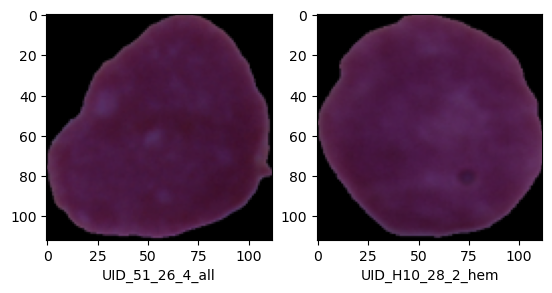

In [17]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(aug_all_images[0])
plt.xlabel(aug_all_ids[0])
plt.subplot(1,2,2)
plt.imshow(aug_hem_images[0])
plt.xlabel(aug_hem_ids[0])

In [18]:
aug_all_features = model_3.predict(aug_all_images)
aug_hem_features = model_3.predict(aug_hem_images)

2023-04-16 12:30:06.511062: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-16 12:30:06.552482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - 7s 31ms/step


In [19]:
aug_all_features_df = pd.DataFrame(aug_all_features, index=aug_all_ids)
aug_hem_features_df = pd.DataFrame(aug_hem_features, index=aug_hem_ids)
aug_all_features_df['labels'] = 1
aug_hem_features_df['labels'] = 0
aug_all_features_df.head()
aug_hem_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,labels
UID_H10_28_2_hem,0.005014,-0.476383,0.010901,-0.008032,0.009128,0.084804,0.001566,-0.009387,0.036233,-0.003966,...,-0.000524,0.049066,0.002832,0.000735,0.002854,-0.002322,-0.019410,-0.039431,0.015359,0
aug__181_2666,-0.677149,2.207440,17.914465,0.617401,2.254408,-0.477481,0.532554,2.345064,0.860176,0.188088,...,-0.000524,0.007308,0.002832,0.000735,0.002854,-0.002322,-0.001426,0.052435,0.015359,0
aug__67_1533,0.070057,1.718898,10.930337,0.254064,1.601236,0.160306,0.388985,0.091015,0.234156,0.141806,...,-0.000524,0.007308,0.002832,0.000735,0.002854,0.002992,-0.003367,-0.418672,0.015359,0
aug__1829_4882,-0.677149,1.734455,11.129365,0.553195,1.521510,-0.285568,0.386232,2.379208,0.680746,0.141908,...,-0.000524,0.007308,0.002832,0.000735,0.002854,-0.002322,0.011297,0.029662,0.015359,0
UID_H40_13_3_hem,-0.017635,-0.564793,0.010901,-0.008032,0.009128,0.066149,-0.009935,-0.009387,0.075778,-0.013535,...,-0.000524,0.028079,0.002832,0.000735,0.002854,-0.002322,-0.012691,-0.295162,0.015359,0


In [20]:
training_df  = pd.concat([aug_hem_features_df, aug_all_features_df])
training_df.labels = training_df.labels.astype('category')

In [21]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14562 entries, UID_H10_28_2_hem to UID_28_24_1_all
Columns: 2049 entries, 0 to labels
dtypes: category(1), float32(2048)
memory usage: 113.9+ MB


In [22]:
training_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,labels
UID_68_11_1_all,0.063827,-0.303812,0.010901,-0.008032,0.009128,0.100546,0.003620,-0.009387,0.051736,-0.004425,...,-0.000524,0.047935,0.002832,0.000735,0.002854,-0.002322,-0.013078,-0.015932,0.015359,1
UID_51_127_7_all,-0.073004,-0.284226,0.010901,-0.008032,0.009128,0.063157,0.011327,-0.009387,0.104209,-0.006514,...,-0.000524,0.038883,0.002832,0.000735,0.002854,-0.002322,-0.012538,-0.096394,0.015359,1
UID_51_61_4_all,0.106750,-0.548388,0.010901,-0.008032,0.009128,0.166754,0.024181,-0.009387,0.013429,-0.005350,...,-0.000524,0.042273,0.002832,0.000735,0.002854,-0.002322,-0.013305,-0.142515,0.015359,1
UID_52_25_17_all,-0.059418,-0.371178,0.010901,-0.008032,0.009128,0.096454,0.020190,-0.009387,0.018572,0.004155,...,-0.000524,0.054581,0.002832,0.000735,0.002854,-0.002322,-0.023436,0.168879,0.015359,1
UID_28_24_1_all,0.042726,-0.370489,0.010901,-0.008032,0.009128,0.141547,-0.000826,-0.009387,0.016338,-0.002665,...,-0.000524,0.055794,0.002832,0.000735,0.002854,-0.002322,-0.013356,0.002485,0.015359,1


In [23]:
training_df.to_pickle('train_data.pickle')

In [24]:
VAL_IMAGE_PATH = VALIDATION_DATA_PATH.joinpath('C-NMC_test_prelim_phase_data')
checkPathExists(VAL_IMAGE_PATH)

Path C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data accessible


In [25]:
RESIZED_VAL_PATH = resizeImagesInFolder(VAL_IMAGE_PATH, IMAGE_SIZE)

Path C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data accessible


In [26]:
VAL_LABELS = pd.read_csv(VALIDATION_DATA_PATH.joinpath('C-NMC_test_prelim_phase_data_labels.csv'))
VAL_LABELS['ID'] = [x.split('.')[0] for x in VAL_LABELS.new_names]
VAL_LABELS = VAL_LABELS.set_index('ID')
VAL_LABELS.head()


,Patient_ID,new_names,labels
ID,,,
1,UID_57_29_1_all.bmp,1.bmp,1
2,UID_57_22_2_all.bmp,2.bmp,1
3,UID_57_31_3_all.bmp,3.bmp,1
4,UID_H49_35_1_hem.bmp,4.bmp,0
5,UID_58_6_13_all.bmp,5.bmp,1


In [27]:
VAL_LABELS.loc['735']

Patient_ID    UID_H25_9_1_hem.bmp
new_names                 735.bmp
labels                          0
Name: 735, dtype: object

In [28]:
val_images, val_ids = LoadData(RESIZED_VAL_PATH)

'735'

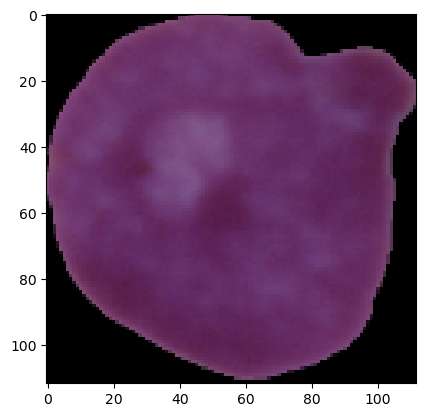

In [29]:
plt.imshow(val_images[0])
val_ids[0]

In [30]:
val_features = model_3.predict(val_images)

59/59 [==============================] - 2s 33ms/step


In [31]:
val_features_df = pd.DataFrame(val_features, index=val_ids)

In [32]:
val_features_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
735,-0.065460,-0.098910,0.010901,-0.008032,0.009128,0.100431,0.045157,-0.009387,0.116936,-0.000546,...,0.008902,0.041768,0.062289,0.002832,0.000735,0.002854,-0.002322,-0.000398,-0.099105,0.015359
721,-0.006836,-0.512995,0.010901,-0.008032,0.009128,0.067583,-0.009935,-0.009387,0.048886,-0.008583,...,0.008902,-0.000524,0.020602,0.002832,0.000735,0.002854,-0.002322,-0.005594,-0.106989,0.015359
709,0.040469,-0.308842,0.010901,-0.008032,0.009128,0.110052,-0.003931,-0.009387,0.048526,-0.004366,...,0.008902,-0.000524,0.007308,0.002832,0.000735,0.002854,-0.002322,-0.002380,-0.342719,0.015359
1289,0.046419,-0.524393,0.010901,-0.008032,0.009128,0.128277,0.002108,-0.009387,0.027570,-0.001390,...,0.008902,-0.000524,0.032594,0.002832,0.000735,0.002854,-0.002322,-0.002345,0.000197,0.015359
1262,0.058412,-0.432239,0.010901,-0.008032,0.009128,0.121205,0.019121,-0.009387,0.049853,-0.000328,...,0.008902,0.026142,0.061511,0.002832,0.000735,0.002854,-0.002322,-0.016642,-0.151882,0.015359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,0.041927,-0.497695,0.010901,-0.008032,0.009128,0.096186,0.012459,-0.009387,0.021767,0.005397,...,0.008902,-0.000524,0.009396,0.002832,0.000735,0.002854,-0.002322,-0.007321,-0.139298,0.015359
704,-0.028380,-0.475670,0.010901,-0.008032,0.009128,0.065834,-0.009935,-0.009387,0.092841,-0.010571,...,0.008902,-0.000524,0.031114,0.002832,0.000735,0.002854,-0.002322,-0.009093,-0.246050,0.015359
710,0.026150,-0.294743,0.010901,-0.008032,0.009128,0.103715,0.003906,-0.009387,0.046770,-0.001466,...,0.008902,-0.000524,0.030151,0.002832,0.000735,0.002854,-0.002322,-0.003074,0.085275,0.015359
1284,-0.028706,-0.520505,0.010901,-0.008032,0.009128,0.074615,-0.009138,-0.009387,0.046960,-0.007522,...,0.008902,-0.000524,0.046653,0.002832,0.000735,0.002854,-0.002322,-0.007735,-0.152653,0.015359


In [33]:
testing_df = pd.concat([val_features_df, VAL_LABELS.labels], axis=1)
testing_df.labels = testing_df.labels.astype('category')

In [34]:
testing_df.shape

(1867, 2049)

In [35]:
testing_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,labels
735,-0.065460,-0.098910,0.010901,-0.008032,0.009128,0.100431,0.045157,-0.009387,0.116936,-0.000546,...,0.041768,0.062289,0.002832,0.000735,0.002854,-0.002322,-0.000398,-0.099105,0.015359,0
721,-0.006836,-0.512995,0.010901,-0.008032,0.009128,0.067583,-0.009935,-0.009387,0.048886,-0.008583,...,-0.000524,0.020602,0.002832,0.000735,0.002854,-0.002322,-0.005594,-0.106989,0.015359,0
709,0.040469,-0.308842,0.010901,-0.008032,0.009128,0.110052,-0.003931,-0.009387,0.048526,-0.004366,...,-0.000524,0.007308,0.002832,0.000735,0.002854,-0.002322,-0.002380,-0.342719,0.015359,1
1289,0.046419,-0.524393,0.010901,-0.008032,0.009128,0.128277,0.002108,-0.009387,0.027570,-0.001390,...,-0.000524,0.032594,0.002832,0.000735,0.002854,-0.002322,-0.002345,0.000197,0.015359,1
1262,0.058412,-0.432239,0.010901,-0.008032,0.009128,0.121205,0.019121,-0.009387,0.049853,-0.000328,...,0.026142,0.061511,0.002832,0.000735,0.002854,-0.002322,-0.016642,-0.151882,0.015359,0


In [36]:
testing_df.to_pickle('testing_data.pickle')